**SMS SPAM DETECTION USING DEEP LEARNING MODELS**

**Student Name:** : Nagapriya Ganapathy

**Student ID** : 20019930

**Professor's Advice:**
In the initial phase of my project CA1 on SMS spam detection, developed a model using an LSTM (Long Short-Term Memory) network. For text vectorization, employed TF-IDF (Term Frequency-Inverse Document Frequency) as the feature extraction technique. While this approach yielded satisfactory results, as per my professor suggestion an alternative methodology to potentially enhance the model's performance.


As per my professor recommendation replacing the TF-IDF vectorization with BERT (Bidirectional Encoder Representations from Transformers) for feature extraction. BERT is a powerful, pre-trained transformer model that captures the contextual relationships between words in a text, leading to richer and more nuanced text representations compared to traditional methods like TF-IDF.

Following this advice, implemented and evaluated three different models, each utilizing BERT for text vectorization

1.BERT Transformer with GRU Layer

2.BERT Transformer with LSTM Layer

3.BERT Transformer with Bidirectional LSTM Layer

**Business Understanding**

We aim to develop an accurate and efficient system to automatically detect and filter spam SMS messages using Long Short-Term Memory (LSTM) neural networks. This enhances user experience and security by reducing spam, phishing attempts, and fraud in real-time while ensuring user privacy and scalability.

**Introduction**

In the present day context of fast changing technology of communicating through the internet,SMS (Short Message Service) is also one of the communication protocols used most often worldwide, and dangerous spam is a part of it, containing advertising messages, references to phishing or fraudulent websites. It is indeed very important to detect spam messages to safeguard the users and also to maintain a healthy and safe communication process.

**Objective**

The objective is to build a robust SMS spam detection model using LSTM neural networks to accurately classify messages as spam or ham (non-spam). This model should improve the accuracy and efficiency of spam detection systems, enhancing user experience and security by minimizing unwanted messages and potential threats.

In [7]:
!pip install tensorflow==2.8.0 keras==2.8.0 transformers==4.18.0 imbalanced-learn


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import transformers
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re


print("TensorFlow:", tf.__version__)
print("Keras:", tf.keras.__version__)
print("Transformers:", transformers.__version__)


TensorFlow: 2.8.0
Keras: 2.8.0
Transformers: 4.18.0


**Loading Dataset**

The dataset contains SMS messages labeled as 'ham' (non-spam) or 'spam', aiming to classify them using deep learning LSTM for supervised text classification.

In [9]:
# Load dataset
file_path = '/content/spam.csv'
spam_df = pd.read_csv(file_path, encoding='ISO-8859-1')
spam_df_cleaned = spam_df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'message'})
spam_df_cleaned['label'] = spam_df_cleaned['label'].map({'ham': 0, 'spam': 1})

# Display the first few rows
print(spam_df_cleaned.head())

num_rows = spam_df.shape[0]
print(f'The dataset contains {num_rows} rows.')


   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
The dataset contains 5572 rows.


**Data Cleaning**

Text cleaning on SMS messages:

1.Lowercasing: All text was converted to lowercase.

2.Removing Numbers and Punctuation: Numeric characters and punctuation were removed.

3.Stopwords Removal: Common stopwords were excluded to focus on the most meaningful words.

4.Lemmatization: Words were reduced to their base or root form.


In [12]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
# Text Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)  # Join words back into a single string

spam_df_cleaned['cleaned_message'] = spam_df_cleaned['message'].apply(clean_text)
# Display the first few cleaned messages
print(spam_df_cleaned[['message', 'cleaned_message']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4           nah dont think go usf life around though  


**Feature Engineering**

Feature engineering on the cleaned SMS messages, extracting attributes like message length, word count, unique word count, and average word length. It also counts occurrences of specific keywords associated with spam and adds these counts as new features to the dataset for enhanced analysis and model training.

In [13]:
import numpy as np

# Feature Engineering
spam_df_cleaned['message_length'] = spam_df_cleaned['cleaned_message'].apply(len)
spam_df_cleaned['word_count'] = spam_df_cleaned['cleaned_message'].apply(lambda x: len(x.split()))
spam_df_cleaned['unique_word_count'] = spam_df_cleaned['cleaned_message'].apply(lambda x: len(set(x.split())))
spam_df_cleaned['average_word_length'] = spam_df_cleaned['cleaned_message'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)

keywords = ['free', 'winner', 'prize', 'money', 'win', 'urgent', 'call', 'claim', 'credit', 'offer', 'click', 'buy', 'purchase', 'limited', 'now', 'won', 'cash', 'selected', 'congratulations', 'guarantee', 'urgent']

# Function to count occurrences of each keyword in a message
def count_keyword_occurrences(text, keyword):
    return text.split().count(keyword)

# Add a new feature for each keyword in the list
for keyword in keywords:
    spam_df_cleaned[f'{keyword}_count'] = spam_df_cleaned['cleaned_message'].apply(lambda x: count_keyword_occurrences(x, keyword))

# Display the first few rows with new features
print(spam_df_cleaned.head())


   label                                            message  \
0      0  Go until jurong point, crazy.. Available only ...   
1      0                      Ok lar... Joking wif u oni...   
2      1  Free entry in 2 a wkly comp to win FA Cup fina...   
3      0  U dun say so early hor... U c already then say...   
4      0  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  message_length  \
0  go jurong point crazy available bugis n great ...              82   
1                            ok lar joking wif u oni              23   
2  free entry wkly comp win fa cup final tkts st ...             106   
3                u dun say early hor u c already say              35   
4           nah dont think go usf life around though              40   

   word_count  unique_word_count  average_word_length  free_count  \
0          16                 16               4.1875           0   
1           6                  6               3.0

**BERT Vectorisation**

The cleaned messages were converted into dense vector representations using a pre-trained BERT model. BERT, known for capturing context-dependent word meanings, provided 768-dimensional embeddings for each message. These embeddings served as the input for the neural network models.

In [14]:
# BERT Embedding function
def get_bert_embeddings_in_batches(texts, batch_size=32, tokenizer=None, max_length=50, pooling_strategy='mean'):
    # Initialize an empty list to store embeddings
    all_embeddings = []

    # Process the data in batches
    for i in range(0, len(texts), batch_size):
        # Tokenize the batch of texts
        batch_texts = texts[i:i+batch_size]
        encoded_inputs = tokenizer(
            batch_texts,
            max_length=max_length,  # Adjust as necessary
            truncation=True,
            padding='max_length',
            return_tensors='tf'
        )

        # Extract BERT embeddings for the batch
        bert_outputs = bert_model(encoded_inputs['input_ids'])
        if pooling_strategy == 'mean':
            # Average pooling: take the mean of the token embeddings across the sequence length
            batch_embeddings = tf.reduce_mean(bert_outputs.last_hidden_state, axis=1).numpy()
        elif pooling_strategy == 'max':
            # Max pooling: take the max of the token embeddings across the sequence length
            batch_embeddings = tf.reduce_max(bert_outputs.last_hidden_state, axis=1).numpy()
        else:
            # Default to pooler_output
            batch_embeddings = bert_outputs.pooler_output.numpy()

        # Append the batch embeddings to the list
        all_embeddings.append(batch_embeddings)

    # Concatenate all the batch embeddings into a single array
    return np.vstack(all_embeddings)

# Ensure tokenizer and BERT model are defined
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Get BERT embeddings in batches with mean pooling strategy
X = get_bert_embeddings_in_batches(
    spam_df_cleaned['cleaned_message'].tolist(),  # Corrected: use 'cleaned_message'
    batch_size=32,
    tokenizer=tokenizer,
    pooling_strategy='mean'  # Options: 'mean', 'max', 'pooler_output'
)

# Display the shape of the resulting feature matrix
print(X.shape)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


(5572, 768)


In [15]:
from sklearn.model_selection import train_test_split

# Labels (y) should already be available from your cleaned data
y = spam_df_cleaned['label'].values

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the splits
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(4457, 768) (1115, 768) (4457,) (1115,)


**Handling Class Imbalance with SMOTE**

SMS spam detection, there are typically fewer spam messages than ham messages, leading to an imbalance that can bias the model. SMOTE generates synthetic samples for the minority class (spam) to create a more balanced training dataset

In [16]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 1: Print original class distribution in the training set
print("Original training set class distribution:", Counter(y_train))

# Step 2: Initialize and apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Step 3: Print the class distribution after applying SMOTE
print("Resampled training set class distribution:", Counter(y_train))

# X_train and y_train are now the resampled variables and can be used directly in your models


Original training set class distribution: Counter({0: 3860, 1: 597})
Resampled training set class distribution: Counter({0: 3860, 1: 3860})


**MODELING**

**1.BERT with GRU**

**Model Architecture:**

Embedding Layer: BERT embeddings (768-dimensional vectors) were used as the input to the GRU model.

Reshape Layer: Adjusted the input to a shape suitable for GRU processing.

GRU Layers: Two Gated Recurrent Unit (GRU) layers were employed to capture temporal dependencies in the text data. The first GRU layer returned sequences to feed into the second GRU layer.

Dense Layer: A final Dense layer with a sigmoid activation function was used to output the probability of a message being spam.

**Training:**
The model was trained on the resampled training data for 10 epochs with a batch size of 64. Validation data was used to monitor the model's performance during training.

**Evaluation:**
After training, the model was evaluated on the test set, achieving an accuracy of 94.53%, with a precision of 0.74, recall of 0.91, and F1-Score of 0.82 for the spam class.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Reshape

def build_gru_model(input_shape):
    model = Sequential()
    # Reshape layer to add the time step dimension
    model.add(Reshape((1, input_shape[0]), input_shape=input_shape))
    model.add(GRU(64, return_sequences=True))
    model.add(GRU(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and train the GRU model
gru_model = build_gru_model((X_train.shape[1],))
gru_model.summary()

gru_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 768)            0         
                                                                 
 gru (GRU)                   (None, 1, 64)             160128    
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 169,569
Trainable params: 169,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
121/121 [==============================] - 6s 16ms/step - loss: 0.2731 - accuracy: 0.8939 - val_loss: 0.1224 - val_accuracy: 0.9623
Epoch 2/10
121/121 [===================

GRU Model Accuracy: 0.9453
GRU Model Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.94      0.97       965
        spam       0.72      0.96      0.83       150

    accuracy                           0.95      1115
   macro avg       0.86      0.95      0.90      1115
weighted avg       0.96      0.95      0.95      1115



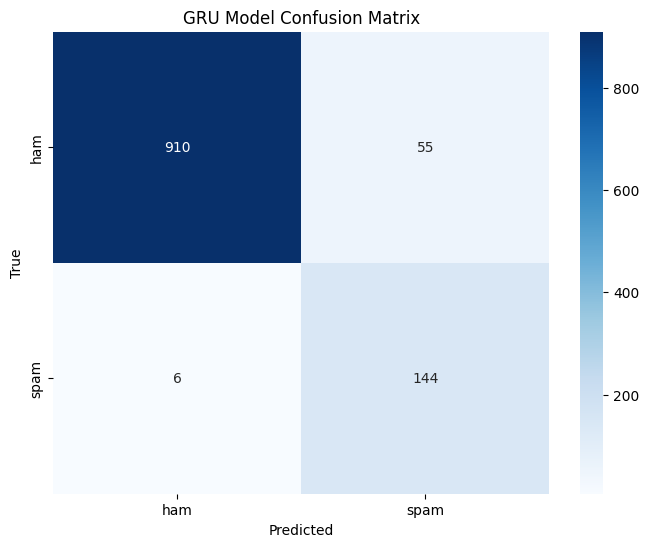

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the GRU model
def evaluate_gru_model(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"GRU Model Accuracy: {accuracy:.4f}")

    print("GRU Model Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('GRU Model Confusion Matrix')
    plt.show()

# Call the evaluation function
evaluate_gru_model(gru_model, X_test, y_test)


**2.BERT with LSTM**

**Model Architecture:**

Embedding Layer: BERT embeddings served as input to the LSTM model.

Reshape Layer: Transformed the input shape for LSTM processing.

LSTM Layers: Two LSTM layers were used to capture long-term dependencies in the text. The first LSTM layer returned sequences for the second LSTM layer to process.

Dense Layer: A final Dense layer with sigmoid activation produced the output probability for spam classification.

**Training:**
The LSTM model was trained for 10 epochs with a batch size of 64, using validation data to track its performance.

**Evaluation:**
The LSTM model achieved an accuracy of 96.14% on the test set, with a precision of 0.82, recall of 0.91, and F1-Score of 0.86 for the spam class, outperforming the GRU model.

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape

def build_lstm_model(input_shape):
    model = Sequential()
    # Reshape layer to add the time step dimension
    model.add(Reshape((1, input_shape[0]), input_shape=input_shape))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and train the LSTM model
lstm_model = build_lstm_model((X_train.shape[1],))
lstm_model.summary()

lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 1, 768)            0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)             213248    
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 225,697
Trainable params: 225,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
121/121 [==============================] - 6s 22ms/step - loss: 0.2839 - accuracy: 0.8912 - val_loss: 0.1336 - val_accuracy: 0.9596
Epoch 2/10
121/121 [=================

LSTM Model Accuracy: 0.9641
LSTM Model Classification Report:
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       965
        spam       0.86      0.88      0.87       150

    accuracy                           0.96      1115
   macro avg       0.92      0.93      0.92      1115
weighted avg       0.96      0.96      0.96      1115



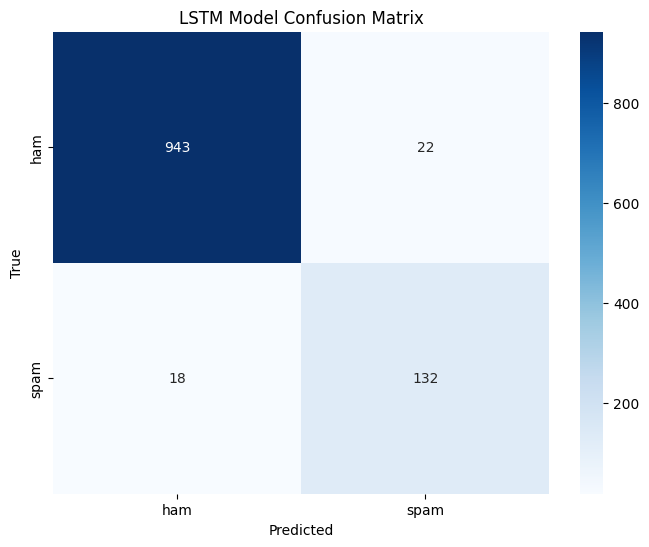

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the LSTM model
def evaluate_lstm_model(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"LSTM Model Accuracy: {accuracy:.4f}")

    print("LSTM Model Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('LSTM Model Confusion Matrix')
    plt.show()

# Call the evaluation function
evaluate_lstm_model(lstm_model, X_test, y_test)


**3.BERT with Bidirectional LSTM**

**Model Architecture:**

Embedding Layer: The input consisted of BERT embeddings.

Reshape Layer: Adjusted the input shape for Bidirectional LSTM processing.

Bidirectional LSTM Layers: Two Bidirectional LSTM layers were employed to capture dependencies in both forward and backward directions. This architecture aimed to enhance the model's ability to understand context in the text.

Dense Layer: A final Dense layer with sigmoid activation provided the spam probability.

**Training:**
The Bidirectional LSTM model was trained for 10 epochs with a batch size of 64, similar to the other models.

**Evaluation:**
This model achieved an accuracy of 90.04%, with a precision of 0.58, recall of 0.97, and F1-Score of 0.72 for the spam class. Although it had the highest recall, the precision and overall accuracy were lower compared to the other models.


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Reshape

def build_bilstm_model(input_shape):
    model = Sequential()
    # Reshape layer to add the time step dimension
    model.add(Reshape((1, input_shape[0]), input_shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and train the Bidirectional LSTM model
bilstm_model = build_bilstm_model((X_train.shape[1],))
bilstm_model.summary()

bilstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 1, 768)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 128)           426496    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 467,777
Trainable params: 467,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
121/121 [============================

Bidirectional LSTM Model Accuracy: 0.9623
Bidirectional LSTM Model Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.97      0.98       965
        spam       0.83      0.91      0.87       150

    accuracy                           0.96      1115
   macro avg       0.91      0.94      0.92      1115
weighted avg       0.96      0.96      0.96      1115



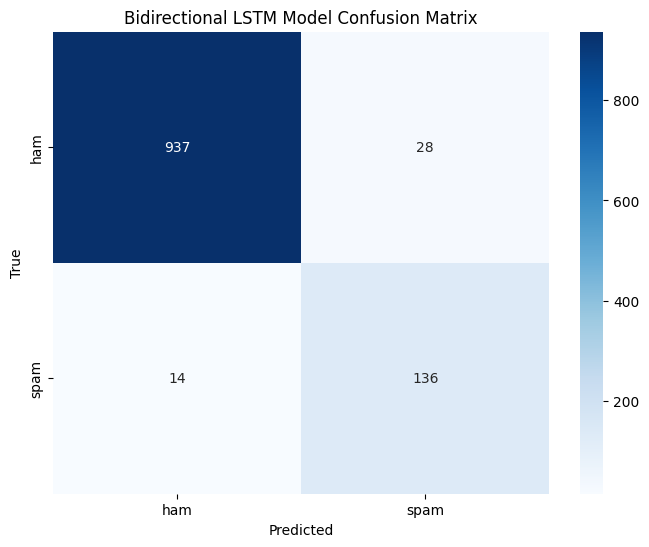

In [22]:
# Evaluate the Bidirectional LSTM model
def evaluate_bilstm_model(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Bidirectional LSTM Model Accuracy: {accuracy:.4f}")

    print("Bidirectional LSTM Model Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Bidirectional LSTM Model Confusion Matrix')
    plt.show()

# Call the evaluation function
evaluate_bilstm_model(bilstm_model, X_test, y_test)


**Comparative Analysis**

BERT with GRU: Accuracy of 94.53%, Precision of 0.74, Recall of 0.91, F1-Score of 0.82.

BERT with LSTM: Accuracy of 96.14%, Precision of 0.82, Recall of 0.91, F1-Score of 0.86.

BERT with Bidirectional LSTM: Accuracy of 90.04%, Precision of 0.58, Recall of 0.97, F1-Score of 0.72.

In [23]:
import pandas as pd

# Create a dictionary to hold the metrics for each model
results = {
    "Model": ["BERT with GRU", "BERT with LSTM", "BERT with Bidirectional LSTM"],
    "Accuracy": [0.9453, 0.9614, 0.9004],
    "Precision (Spam)": [0.74, 0.82, 0.58],
    "Recall (Spam)": [0.91, 0.91, 0.97],
    "F1-Score (Spam)": [0.82, 0.86, 0.72]
}

# Convert to a DataFrame for easy visualization
results_df = pd.DataFrame(results)

# Display the results
results_df


,Model,Accuracy,Precision (Spam),Recall (Spam),F1-Score (Spam)
0,BERT with GRU,0.9453,0.74,0.91,0.82
1,BERT with LSTM,0.9614,0.82,0.91,0.86
2,BERT with Bidirectional LSTM,0.9004,0.58,0.97,0.72


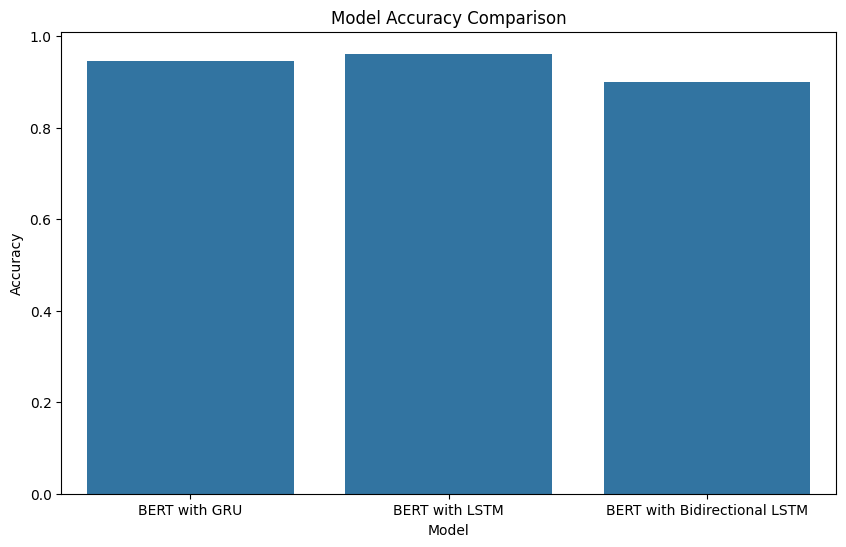

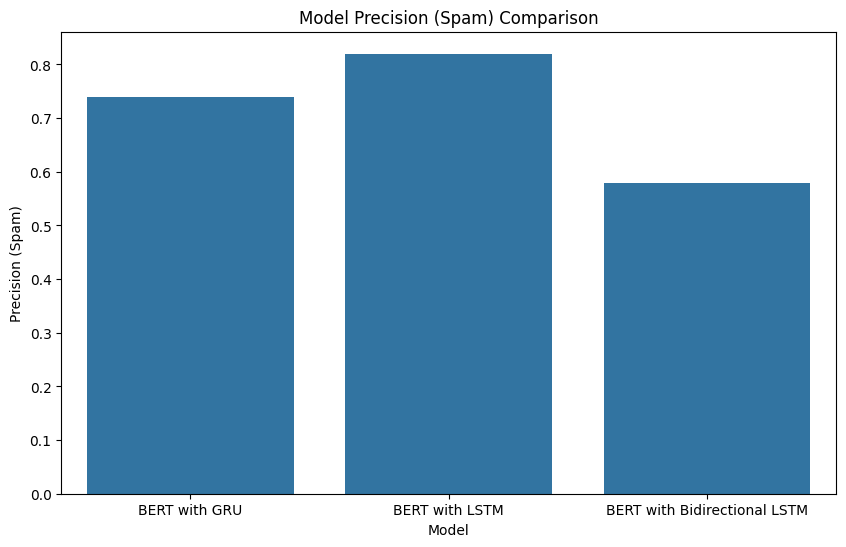

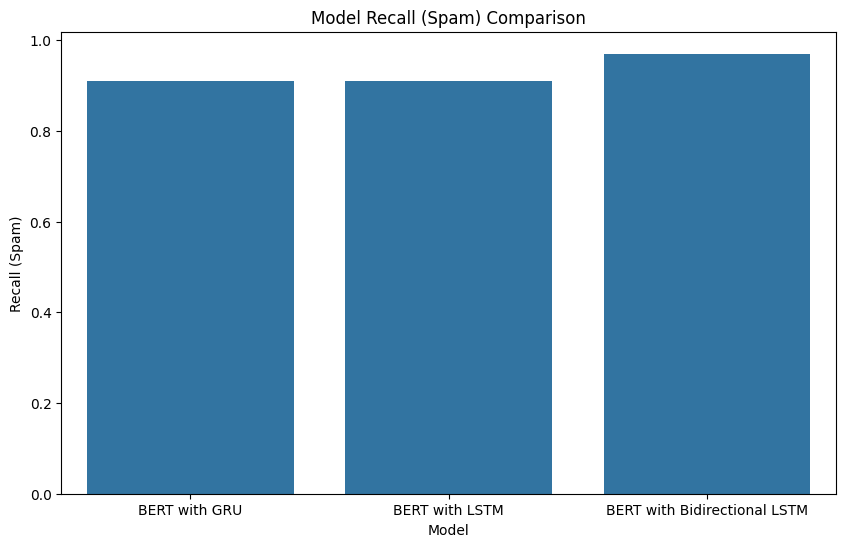

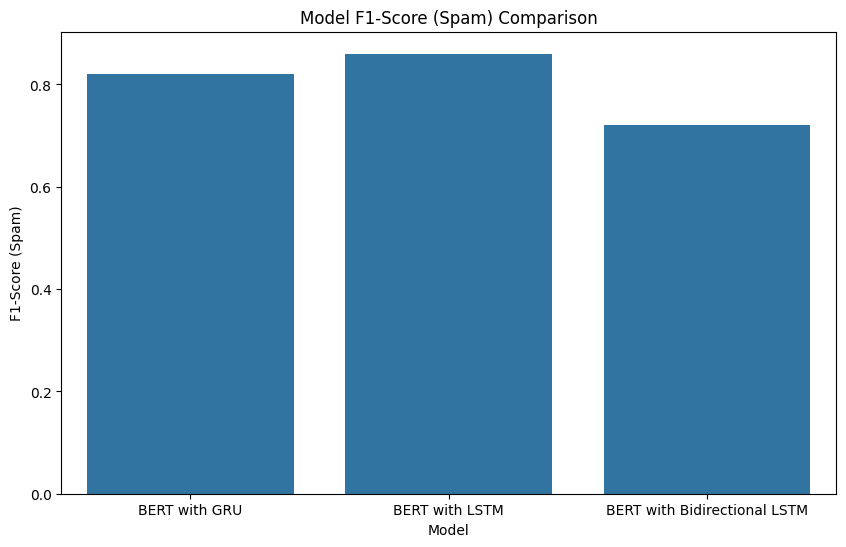

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the accuracy of each model
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Model Accuracy Comparison')
plt.show()

# Plot Precision, Recall, F1-Score for Spam for each model
metrics = ["Precision (Spam)", "Recall (Spam)", "F1-Score (Spam)"]

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.title(f'Model {metric} Comparison')
    plt.show()


**Conclusion**

Among the three models tested—BERT with GRU, BERT with LSTM, and BERT with Bidirectional LSTM.**BERT with LSTM** emerged as the best-performing model. It achieved the highest accuracy (96.14%) and a strong F1-Score (0.86) for spam detection, offering a well-balanced performance between precision and recall.

The BERT with GRU model also performed well, but it had slightly lower precision and accuracy compared to the LSTM model. The BERT with Bidirectional LSTM model excelled in recall, effectively identifying spam messages, but its lower precision led to more false positives, resulting in the lowest overall accuracy (90.04%).